In [9]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [10]:
data = pd.read_csv('../Data/ver1.csv', index_col=0)
data.drop(["index"], inplace = True, axis=1)

In [11]:
data

,Text,oh_label
0,Im 12 and i can understand it perfectly. You s...,1.0
1,"#mkr Boy, @FourinHandyou sure know how to dish...",0.0
2,Fuck you all. This site is full of stuck up ...,1.0
3,"` ::I don't disagree with your point, except...",0.0
4,"do i look like i give a fuck, u are all sad ...",1.0
...,...,...
99995,` == d15b8 - just you leave it alone == ``co...,0.0
99996,":Thanks for the feedback, and I'm very glad t...",0.0
99997,==Fast and Furious 7== Please do your resear...,0.0
99998,@KWiebs31 ABLOO BLOO BLOO,0.0


In [12]:
data.columns = ['Text', 'oh_label']

In [13]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [14]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]
# tokens

In [15]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens] 

In [16]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [6]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [7]:
result = [' '.join(sen) for sen in filtered_words]

In [ ]:
data['Text_Final'] = result

In [ ]:
data = data[['Text', 'oh_label']]

In [ ]:
data

In [ ]:
x_neg_weight = data[data["oh_label"]==1].shape
x_pos_weight = data[data["oh_label"]==0].shape
x_neg_weight[0]/x_pos_weight[0]

In [ ]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-50')

In [ ]:
data["Text"]

In [ ]:
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}

In [ ]:
import swifter
import re
import nltk
import string

MAX_NUMBER_OF_WORDS = 50
ENCODE_SIZE = 50
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

def get_vector(word):
    try:
        return glove_vectors.get_vector(word)
    except Exception as e:
#         print(e)
        pass
    return np.zeros((ENCODE_SIZE,))

def precoess_row(text):
    text = remove_punct(re.sub(r'\d+', 'number', text))
    vec = np.array([get_vector(word.lower()) for word in nltk.word_tokenize(text)])
    if vec.shape[0] == 0:
        return np.nan
    if vec.shape[0] >= MAX_NUMBER_OF_WORDS:
        vec = vec[:MAX_NUMBER_OF_WORDS,:]
    else:
        vec = np.vstack((vec,np.zeros((MAX_NUMBER_OF_WORDS-vec.shape[0],ENCODE_SIZE))))
    return vec

In [ ]:
data["Final"] = data["Text"].swifter.apply(precoess_row)

In [ ]:
df = data[["Final", "oh_label"]]
df

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [20]:
df.index

Int64Index([75328,  7509, 46247, 27080, 58945, 47338, 70231, 63530, 68352,
            77903,
            ...
            31780, 63255, 87529, 18305, 39026, 84820, 80333, 12697, 35475,
            97662],
           dtype='int64', length=100000)

In [21]:
df["Final"] = df["Final"].dropna(axis=0)

In [22]:
lst = []
ignored = []
for a in zip(df.index, df["Final"]):
    try:
        if a[1].shape == (50,50):
            lst.append(a[1])
    except:
        ignored.append(a[0])

In [23]:
ignored

[50022,
 63261,
 30918,
 40442,
 1228,
 23680,
 5765,
 21064,
 30578,
 46271,
 26189,
 49114]

In [24]:
X = np.stack(lst)#a
y = df.drop(ignored)
y= y["oh_label"]

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [600]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
from keras.regularizers import l2, l1
model = Sequential()
model.add(LSTM(50, input_shape=(50, 50), recurrent_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(25,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_77 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 26        
Total params: 21,501
Trainable params: 21,501
Non-trainable params: 0
_________________________________________________________________


In [573]:
np.expand_dims(x_train,axis=-1).shape,y_train.shape

((74970, 50, 50, 1), (74970,))

In [580]:
NUM_WORKERS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
history = model.fit(x_train,y_train.values, batch_size =200, epochs = 500,validation_split=0.1,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/500
338/338 [==============================] - 73s 211ms/step - loss: 0.1728 - accuracy: 0.8280 - val_loss: 0.3573 - val_accuracy: 0.8413
Epoch 2/500
338/338 [==============================] - 72s 212ms/step - loss: 0.1431 - accuracy: 0.8470 - val_loss: 0.3413 - val_accuracy: 0.8421
Epoch 3/500
338/338 [==============================] - 77s 228ms/step - loss: 0.1370 - accuracy: 0.8564 - val_loss: 0.3165 - val_accuracy: 0.8693
Epoch 4/500
338/338 [==============================] - 70s 208ms/step - loss: 0.1296 - accuracy: 0.8652 - val_loss: 0.3153 - val_accuracy: 0.8659
Epoch 5/500
338/338 [==============================] - 72s 212ms/step - loss: 0.1272 - accuracy: 0.8654 - val_loss: 0.3179 - val_accuracy: 0.8711
Epoch 6/500
338/338 [==============================] - 69s 204ms/step - loss: 0.1238 - accuracy: 0.8701 - val_loss: 0.3377 - val_accuracy: 0.8550
Epoch 7/500
338/338 [==============================] - 73s 216ms/step - loss: 0.1206 - accuracy: 0.8729 - val_loss: 0.3194 -

Epoch 57/500
338/338 [==============================] - 69s 205ms/step - loss: 0.0298 - accuracy: 0.9702 - val_loss: 0.4815 - val_accuracy: 0.8938
Epoch 58/500
338/338 [==============================] - 69s 205ms/step - loss: 0.0309 - accuracy: 0.9686 - val_loss: 0.5219 - val_accuracy: 0.8733
Epoch 59/500
338/338 [==============================] - 69s 205ms/step - loss: 0.0308 - accuracy: 0.9688 - val_loss: 0.4980 - val_accuracy: 0.8934
Epoch 60/500
338/338 [==============================] - 69s 204ms/step - loss: 0.0291 - accuracy: 0.9701 - val_loss: 0.4738 - val_accuracy: 0.8913
Epoch 61/500
338/338 [==============================] - 69s 205ms/step - loss: 0.0281 - accuracy: 0.9716 - val_loss: 0.5235 - val_accuracy: 0.8933
Epoch 62/500
338/338 [==============================] - 69s 203ms/step - loss: 0.0283 - accuracy: 0.9712 - val_loss: 0.4234 - val_accuracy: 0.8858
Epoch 63/500
338/338 [==============================] - 69s 205ms/step - loss: 0.0277 - accuracy: 0.9718 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


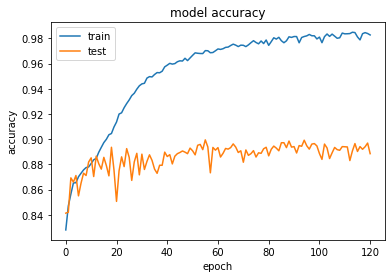

In [583]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

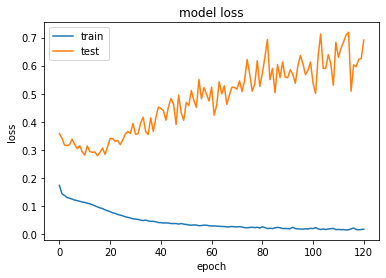

In [584]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [589]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     18334
         1.0       0.75      0.84      0.80      6657

    accuracy                           0.88     24991
   macro avg       0.85      0.87      0.86     24991
weighted avg       0.89      0.88      0.89     24991



In [601]:
NUM_WORKERS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
history = model.fit(x_train,y_train.values, batch_size =300, epochs = 500,validation_split=0.2,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/500
200/200 [==============================] - 18s 84ms/step - loss: 0.3536 - accuracy: 0.5369 - val_loss: 0.4300 - val_accuracy: 0.8279
Epoch 2/500
200/200 [==============================] - 19s 93ms/step - loss: 0.1660 - accuracy: 0.8404 - val_loss: 0.4102 - val_accuracy: 0.8311
Epoch 3/500
200/200 [==============================] - 20s 100ms/step - loss: 0.1514 - accuracy: 0.8540 - val_loss: 0.3365 - val_accuracy: 0.8631
Epoch 4/500
200/200 [==============================] - 21s 108ms/step - loss: 0.1429 - accuracy: 0.8619 - val_loss: 0.3327 - val_accuracy: 0.8630
Epoch 5/500
200/200 [==============================] - 20s 101ms/step - loss: 0.1387 - accuracy: 0.8633 - val_loss: 0.3055 - val_accuracy: 0.8748
Epoch 6/500
200/200 [==============================] - 22s 110ms/step - loss: 0.1357 - accuracy: 0.8648 - val_loss: 0.3496 - val_accuracy: 0.8522
Epoch 7/500
200/200 [==============================] - 20s 102ms/step - loss: 0.1325 - accuracy: 0.8681 - val_loss: 0.3211 - v

200/200 [==============================] - 21s 104ms/step - loss: 0.0773 - accuracy: 0.9181 - val_loss: 0.3557 - val_accuracy: 0.8815
Epoch 112/500
200/200 [==============================] - 19s 94ms/step - loss: 0.0755 - accuracy: 0.9209 - val_loss: 0.3662 - val_accuracy: 0.8739
Epoch 113/500
200/200 [==============================] - 19s 94ms/step - loss: 0.0764 - accuracy: 0.9202 - val_loss: 0.3705 - val_accuracy: 0.8647
Epoch 114/500
200/200 [==============================] - 19s 94ms/step - loss: 0.0744 - accuracy: 0.9223 - val_loss: 0.3798 - val_accuracy: 0.8762
Epoch 115/500
200/200 [==============================] - 19s 93ms/step - loss: 0.0753 - accuracy: 0.9213 - val_loss: 0.3551 - val_accuracy: 0.8770
Epoch 116/500
200/200 [==============================] - 19s 93ms/step - loss: 0.0752 - accuracy: 0.9218 - val_loss: 0.4132 - val_accuracy: 0.8505
Epoch 117/500
200/200 [==============================] - 19s 93ms/step - loss: 0.0763 - accuracy: 0.9200 - val_loss: 0.3885 - val_a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


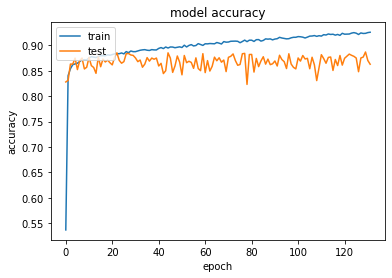

In [602]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

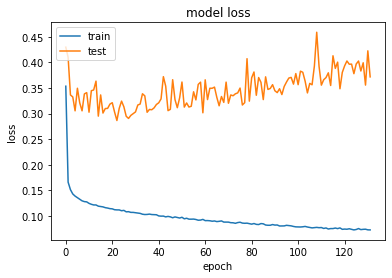

In [603]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [604]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     18334
         1.0       0.68      0.89      0.77      6657

    accuracy                           0.86     24991
   macro avg       0.82      0.87      0.84     24991
weighted avg       0.88      0.86      0.87     24991



In [4]:
# from tensorflow.keras.models import Sequential,Model
# from tensorflow.keras.layers import Dense,Dropout
# import tensorflow as tf
# from keras.regularizers import l2, l1
# model = Sequential()
# model.add(LSTM(10, input_shape=(50, 50), kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])
# model.summary()

In [5]:
# NUM_WORKERS = 10
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# history = model.fit(x_train,y_train.values, batch_size =200, epochs = 60,validation_split=0.3,class_weight=weights,
#                     use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

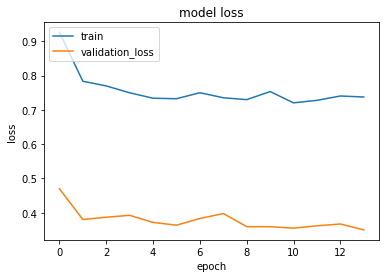

In [638]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation_loss'], loc='upper left')
plt.show()

In [75]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     18315
         1.0       0.68      0.74      0.71      6682

    accuracy                           0.84     24997
   macro avg       0.79      0.81      0.80     24997
weighted avg       0.84      0.84      0.84     24997



In [69]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
import tensorflow as tf
from keras.regularizers import l2, l1
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(50, 50), kernel_regularizer=l2(0.01)))
model.add(LSTM(1, input_shape=(50, 50), kernel_regularizer=l2(0.01)))
# model.add(Dense(5, activation="sigmoid",kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.0001)))
# model.add(Dropout(0.3))
model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 1)             208       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1)                 12        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [72]:
NUM_WORKERS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train,y_train.values, batch_size =150, epochs = 60,validation_split=0.3,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/60
350/350 [==============================] - 20s 57ms/step - loss: 0.2728 - accuracy: 0.5520 - val_loss: 0.6871 - val_accuracy: 0.5549
Epoch 2/60
350/350 [==============================] - 19s 54ms/step - loss: 0.2372 - accuracy: 0.6893 - val_loss: 0.4350 - val_accuracy: 0.8498
Epoch 3/60
350/350 [==============================] - 22s 62ms/step - loss: 0.1794 - accuracy: 0.8395 - val_loss: 0.4016 - val_accuracy: 0.8563
Epoch 4/60
350/350 [==============================] - 19s 55ms/step - loss: 0.1745 - accuracy: 0.8420 - val_loss: 0.4535 - val_accuracy: 0.8302
Epoch 5/60
350/350 [==============================] - 19s 56ms/step - loss: 0.1684 - accuracy: 0.8484 - val_loss: 0.3647 - val_accuracy: 0.8650
Epoch 6/60
350/350 [==============================] - 20s 56ms/step - loss: 0.1664 - accuracy: 0.8479 - val_loss: 0.3981 - val_accuracy: 0.8537
Epoch 7/60
350/350 [==============================] - 19s 54ms/step - loss: 0.1650 - accuracy: 0.8461 - val_loss: 0.3636 - val_accuracy:

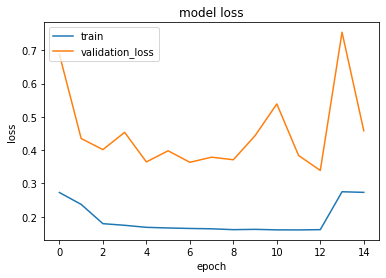

In [73]:
# summarize history for loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation_loss'], loc='upper left')
plt.show()

In [74]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     18315
         1.0       0.68      0.74      0.71      6682

    accuracy                           0.84     24997
   macro avg       0.79      0.81      0.80     24997
weighted avg       0.84      0.84      0.84     24997



In [80]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
import tensorflow as tf
from keras.regularizers import l2, l1
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(50, 50), kernel_regularizer=l2(0.01)))
model.add(LSTM(10, input_shape=(50, 50), kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.0001)))
# model.add(Dropout(0.3))
model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50, 1)             208       
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
_________________________________________________________________
dropout_14 (Dropout)         (None, 1)                 0         
Total params: 699
Trainable params: 699
Non-trainable params: 0
_________________________________________________________________


In [81]:
NUM_WORKERS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train,y_train.values, batch_size =100, epochs = 60,validation_split=0.3,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/60
525/525 [==============================] - 33s 57ms/step - loss: 1.1141 - accuracy: 0.6585 - val_loss: 0.6125 - val_accuracy: 0.7314
Epoch 2/60
525/525 [==============================] - 31s 58ms/step - loss: 1.1082 - accuracy: 0.6128 - val_loss: 0.5944 - val_accuracy: 0.7314
Epoch 3/60
525/525 [==============================] - 34s 64ms/step - loss: 1.1201 - accuracy: 0.5727 - val_loss: 0.5987 - val_accuracy: 0.7314
Epoch 4/60
525/525 [==============================] - 29s 56ms/step - loss: 1.0833 - accuracy: 0.5387 - val_loss: 0.5929 - val_accuracy: 0.7314
Epoch 5/60
525/525 [==============================] - 30s 57ms/step - loss: 1.1024 - accuracy: 0.5904 - val_loss: 0.5994 - val_accuracy: 0.7314
Epoch 6/60
525/525 [==============================] - 30s 57ms/step - loss: 1.0982 - accuracy: 0.5553 - val_loss: 0.5896 - val_accuracy: 0.7314
Epoch 7/60
525/525 [==============================] - 30s 57ms/step - loss: 1.0816 - accuracy: 0.5647 - val_loss: 0.6012 - val_accuracy:

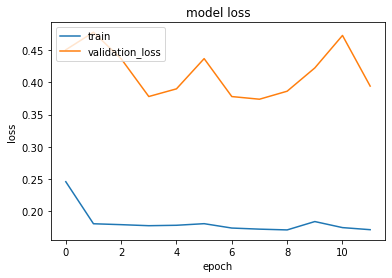

In [78]:
# summarize history for loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation_loss'], loc='upper left')
plt.show()

In [2]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
import tensorflow as tf
from keras.regularizers import l2, l1
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(50, 50), kernel_regularizer=l2(0.25)))
model.add(LSTM(10, input_shape=(50, 50), kernel_regularizer=l2(0.25)))
model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.25)))
model.add(Dropout(0.3))
# model.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.0001)))
# model.add(Dropout(0.3))
model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])
model.summary()

In [3]:
NUM_WORKERS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train,y_train.values, batch_size =150, epochs = 60,validation_data=(x_test,y_test.values),class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])